In [1]:

import os
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer
from xl_durel_utils import tokenize_truncate_decode, calculate_spearman, calculate_krippendorff, plot
from sentence_transformers import SentenceTransformer, models
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

/projekte/cik/shared/llm/XL-DURel/venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load model and tokenizer

model = SentenceTransformer('sachinn1/xl-durel')
tokenizer = AutoTokenizer.from_pretrained("sachinn1/xl-durel")


In [ ]:
# Load the datasets

dev_df = pd.read_pickle("/projekte/cik/shared/llm/thesis/Semantic_Proximity/data/comedi-wic-mclwic/dev.pkl")
test_df = pd.read_pickle("/projekte/cik/shared/llm/thesis/Semantic_Proximity/data/comedi-wic-mclwic/test.pkl")


In [ ]:

# Compute cosine similarities
def compute_similarity(df):
    similarities = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Computing similarities"):
        sent1 = row["sentence1"]
        sent2 = row["sentence2"]
        pos1 = row["position1"]
        pos2 = row["position2"]

        try:
            context1 = tokenize_truncate_decode(sent1, pos1, tokenizer, max_seq_len=128)
            context2 =tokenize_truncate_decode(sent2, pos2, tokenizer, max_seq_len=128)
            emb1 = model.encode(context1, convert_to_tensor=True)
            emb2 = model.encode(context2, convert_to_tensor=True)
            
            sim = cosine_similarity(
                emb1.unsqueeze(0).cpu().numpy(),
                emb2.unsqueeze(0).cpu().numpy()
            )[0][0]

        except Exception as e:
            print(f"Failed : {e}")

        similarities.append(sim)

    df = df.copy()
    df["similarity"] = similarities
    return df

# Run it
dev_df_with_sim = compute_similarity(dev_df)
test_df_with_sim = compute_similarity(test_df)


Computing similarities:   0%|          | 0/863 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Token indices sequence length is longer than the specified maximum sequence length for this model (134 > 128). Running this sequence through the model will result in indexing errors
Computing similarities: 100%|██████████| 2444/2444 [01:15<00:00, 32.34it/s]


/projekte/cik/shared/llm/XL-DURel/venv/lib64/python3.13/site-packages/xl_durel_utils/core.py:237: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = pivot_df.applymap(lambda x: f"{x:.2f}".lstrip("0") if pd.notnull(x) else "")
/projekte/cik/shared/llm/XL-DURel/venv/lib64/python3.13/site-packages/xl_durel_utils/core.py:254: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


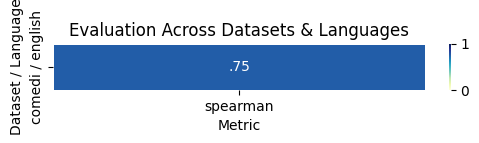

/projekte/cik/shared/llm/XL-DURel/venv/lib64/python3.13/site-packages/xl_durel_utils/core.py:237: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = pivot_df.applymap(lambda x: f"{x:.2f}".lstrip("0") if pd.notnull(x) else "")
/projekte/cik/shared/llm/XL-DURel/venv/lib64/python3.13/site-packages/xl_durel_utils/core.py:254: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


('comedi', 'english') [-inf, 0.32535901204859474, 0.48300452735758276, 0.6115888591099456, inf]


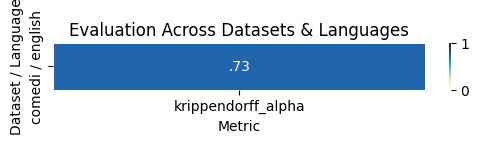

,dataset,language,pearson,spearman
0,comedi,english,0.755052,0.749389


,dataset,language,krippendorff_alpha
0,comedi,english,0.733866


In [ ]:
df1 =calculate_spearman(test_df_with_sim, ["dataset", "language"])
plot(df1, ["spearman"], ["dataset", "language"])    
df2 = calculate_krippendorff(dev_df_with_sim, test_df_with_sim, ["dataset", "language"])
plot(df2, ["krippendorff_alpha"], ["dataset", "language"])    

display(df1)
display(df2)
